In [ ]:
! pip install -r requirements.txt

## API Keys

In [ ]:
# set your API keys in the .env file..
import os
from dotenv import load_dotenv

load_dotenv()

assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY is not set"
assert os.getenv("LANGCHAIN_API_KEY"), "LANGCHAIN_API_KEY is not set"
assert os.getenv("YOUTUBE_API_KEY"), "YOUTUBE_API_KEY is not set"

## Tracability

In [ ]:
from langchain.callbacks.tracers.langchain import LangChainTracer

tracer = LangChainTracer()

## System Prompts

In [ ]:
from langchain_core.messages import SystemMessage

sp1=SystemMessage(content="""Return a comma separated list of exactly 5 valid YouTube video IDs 
that are most relevant to the user's query.
For example: 'id1,id2,id3,id4,id5'""")

sp2=SystemMessage(content="Use the context below to answer the question.")

## Tools

In [ ]:
from langchain_core.tools import Tool
from youtube_transcript_api import YouTubeTranscriptApi
from googleapiclient.discovery import build

YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

def youtube_search(query, max_results=5):
    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=os.getenv("YOUTUBE_API_KEY"))
    search_response = youtube.search().list(
        q=query,
        type="video",
        part="id,snippet",
        maxResults=max_results
    ).execute()

    results = []
    for item in search_response["items"]:
        video_id = item["id"]["videoId"]
        title = item["snippet"]["title"]
        results.append({"title": title, "video_id": video_id})

    return results

youtube_search_tool = Tool.from_function(
    func=youtube_search,
    name="youtube_search",
    description="Search for ID's of youtube videos that are most relevant to a user's query"
)

def fetch_youtube_transcript(video_id):
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return "\n".join([t['text'] for t in transcript])
    except Exception as e:
        return f"Error fetching transcript: {e}"

youtube_transcript_tool = Tool.from_function(
    func=fetch_youtube_transcript,
    name="fetch_youtube_transcript",
    description="Returns the full transcript of a YouTube video given its video ID (e.g., 'xZX4KHrqwhM')."
)

## LLM

In [21]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain.agents import initialize_agent, AgentType

# create the LLM
llm = ChatOpenAI(
    model="gpt-4o", 
    temperature=0,
    callbacks=[tracer]
    )

# create the Agent with tools
agent = initialize_agent(
    tools=[youtube_search_tool, youtube_transcript_tool],
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,  # or AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION
    verbose=True
)

prompt_videos = ChatPromptTemplate.from_messages([
    ("system", """Return a comma separated list of exactly 5 valid YouTube video IDs that are most 
                  relevant to the user's query. 
                  For example: 'id1,id2,id3,id4,id5'"""),
    ("human", "{query}")
])

prompt_video_transcript= ChatPromptTemplate.from_messages([
    ("system", """Return the youtube transcript for the given video ID"""),
    ("human", "{query}")
])

prompt_answer = ChatPromptTemplate.from_messages([
    ("system", "Use the context below to answer the question."),
    ("human", "{query}\n\nContext:\n{context}")
])


## Knowledgebase

In [22]:
# set up any Embeddings/Vector DB's here
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings()

vectorstore = None  # Global FAISS store

## Graph Nodes/Lambdas

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

def step_get_video_ids(state):
    query = state["query"]
    video_ids=[]
    messages = prompt_videos.invoke({"query": query})
    response = agent.invoke(messages)
    video_ids = response['output'].split(',')
    print(f"Retrieved and filtered Video IDs: {video_ids}")
    return {"query": query, "video_ids": video_ids}

def step_get_transcripts(state):
    video_ids = state["video_ids"]
    docs = []
    for vid in video_ids:
        try:
            messages = prompt_video_transcript.invoke({"query": query})
            response = agent.invoke(messages)
            docs.append(Document(page_content=response['output'], metadata={"video_id": vid}))
        except Exception:
            print("⚠️ warning: No transcript was retrieved for video {vid}.")
            continue
    if not docs:
        print("⚠️ Wwarning: No transcripts were retrieved for the given video IDs.")
    return {"query": state["query"], "documents": docs}

def step_embed_docs(state):
    docs = state["documents"]
    if docs:
        splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
        chunks = splitter.split_documents(docs)
        global vectorstore
        vectorstore = FAISS.from_documents(chunks, embedding_model)
    return {"query": state["query"]}

def step_rag_answer(state):
    context=''
    if vectorstore:
        retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
        results = retriever.invoke(state["query"])
        context = "\n\n".join(doc.page_content for doc in results)
    messages = prompt_answer.invoke({"query": state["query"], "context": context})
    response = agent.invoke(messages)
    return {"answer": response['output']}

## Orchestrator

In [24]:
# set up LangChain/LangGraph here
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
import operator

class State(TypedDict):
    query: str
    video_ids: List[str]
    documents: List[Document]
    answer: str

graph = StateGraph(State)
graph.add_node("get_video_ids", RunnableLambda(step_get_video_ids))
graph.add_node("get_transcripts", RunnableLambda(step_get_transcripts))
graph.add_node("embed_docs", RunnableLambda(step_embed_docs))
graph.add_node("rag_answer", RunnableLambda(step_rag_answer))

graph.set_entry_point("get_video_ids")
graph.add_edge("get_video_ids", "get_transcripts")
graph.add_edge("get_transcripts", "embed_docs")
graph.add_edge("embed_docs", "rag_answer")
graph.set_finish_point("rag_answer")

app = graph.compile()


## The Graph

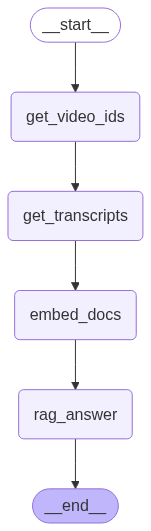

In [25]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Kick off the Query

In [26]:
query = "What are quantum effects in biology?"
result = app.invoke({"query": query})
print("📥 Final RAG Answer:\n")
print(result["answer"])



> Entering new AgentExecutor chain...

Invoking: `youtube_search` with `quantum effects in biology`


[{'title': 'Quantum Effects in Biology Cedric Weber', 'video_id': 'v1CP7mIioTM'}, {'title': 'What if quantum physics could eradicate illness? | Jim Al-Khalili for Big Think', 'video_id': 'E6caolDAcgs'}, {'title': 'Quantum Effects in Biology', 'video_id': '1p365E4c-8E'}, {'title': 'What Is Quantum Biology? - Science Through Time', 'video_id': 'uRCUi7Hzr2A'}, {'title': 'Brain Really Uses Quantum Effects, New Study Finds', 'video_id': 'R6G1D2UQ3gg'}]v1CP7mIioTM,E6caolDAcgs,1p365E4c-8E,uRCUi7Hzr2A,R6G1D2UQ3gg

> Finished chain.
Retrieved and filtered Video IDs: ['v1CP7mIioTM', 'E6caolDAcgs', '1p365E4c-8E', 'uRCUi7Hzr2A', 'R6G1D2UQ3gg']


> Entering new AgentExecutor chain...

Invoking: `youtube_search` with `quantum effects in biology`


[{'title': 'Quantum Effects in Biology Cedric Weber', 'video_id': 'v1CP7mIioTM'}, {'title': 'What if quantum physics could eradicate illness? | Jim Al-K